In [4]:
from functools import partial
import json
import os
import pickle

from datetime import datetime
import ee
import geemap
from multiprocessing.dummy import Pool as ThreadPool
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

import sys
sys.path.append('../')
from scripts.get_s2_data_ee import get_history, get_history_polygon, get_pixel_vectors

%load_ext autoreload
%autoreload 2

In [5]:
# Configuration:
# Set directory where training site json files are located and files are saved
# Set rect width for all patches that are not TPA sites
DATA_DIR = '../data/training_sites'
RECT_WIDTH = 0.002
ee.Initialize()

In [6]:
def load_points(file_name):
    """Load points saved as a GeoJSON and return a dictionary"""
    with open(os.path.join(DATA_DIR, file_name)) as f:
        sites = json.load(f)
    f.close()

    site_table = pd.DataFrame({
        'name': [file_name.split('_')[0] + '_' + str(index) for index in range(len(sites['features']))],
        'lon': [site['geometry']['coordinates'][0] for site in sites['features']],
        'lat': [site['geometry']['coordinates'][1] for site in sites['features']],
        'coords': [site['geometry']['coordinates'][0:2] for site in sites['features']],
    })
    
    return site_table

In [7]:
def sample_adjacent(tpa_sites, offset, direction='east'):
    """
    Create a function that outputs a data frame of sampling locations based on a distance
    and direction from each TPA site.
    This can be used for adjacent site sampling, or to create "random" negative sites if the
    offset distance is set further away from the TPA location.
    Returns a data frame
    """
    if  'east' in direction.lower():
        adjacent_sites = pd.DataFrame({
            'name': [f"{name}_{direction.lower()}_{offset}" for name in tpa_sites['name']],
            'lon': [lon + offset for lon in tpa_sites['lon']],
            'lat': [lat for lat in tpa_sites['lat']],
            'coords': [[lon + offset, lat] for lon, lat in zip(tpa_sites['lon'], tpa_sites['lat'])]
        })
        
    if  'west' in direction.lower():
        adjacent_sites = pd.DataFrame({
            'name': [f"{name}_{direction.lower()}_{offset}" for name in tpa_sites['name']],
            'lon': [lon - offset for lon in tpa_sites['lon']],
            'lat': [lat for lat in tpa_sites['lat']],
            'coords': [[lon + offset, lat] for lon, lat in zip(tpa_sites['lon'], tpa_sites['lat'])]
        })
    
    if  'north' in direction.lower():
        adjacent_sites = pd.DataFrame({
            'name': [f"{name}_{direction.lower()}_{offset}" for name in tpa_sites['name']],
            'lon': [lon for lon in tpa_sites['lon']],
            'lat': [lat + offset for lat in tpa_sites['lat']],
            'coords': [[lon + offset, lat] for lon, lat in zip(tpa_sites['lon'], tpa_sites['lat'])]
        })
    
    if  'south' in direction.lower():
        adjacent_sites = pd.DataFrame({
            'name': [f"{name}_{direction.lower()}_{offset}" for name in tpa_sites['name']],
            'lon': [lon for lon in tpa_sites['lon']],
            'lat': [lat - offset for lat in tpa_sites['lat']],
            'coords': [[lon + offset, lat] for lon, lat in zip(tpa_sites['lon'], tpa_sites['lat'])]
        })
    
    return adjacent_sites

In [8]:
# Load TPA dataset
with open(os.path.join(DATA_DIR, 'tpa_points.json')) as f:
    tpa_points = json.load(f)
    f.close()

tpa_sites = pd.DataFrame({
    'name': [site['properties']['Name'] for site in tpa_points['features']],
    'lon': [site['geometry']['coordinates'][0] for site in tpa_points['features']],
    'lat': [site['geometry']['coordinates'][1] for site in tpa_points['features']],
    'area': [site['properties']['Surface_Ha'] for site in tpa_points['features']],
    'daily_volume': [site['properties']['TOT_Kg/Day'] for site in tpa_points['features']],
    'coords': [site['geometry']['coordinates'] for site in tpa_points['features']]
})


# Add TPA Polygons to TPA dataframe
with open(os.path.join(DATA_DIR, 'tpa_polygons', 'tpa_polygons.json'), 'r') as f:
    json_tpa = json.load(f)
f.close()
tpa_polygons = [ee.FeatureCollection([element]) for element in list(json_tpa['features'])]
tpa_sites['polygons'] = tpa_polygons
display(tpa_sites.head())


,name,lon,lat,area,daily_volume,coords,polygons
0,TPA Jungut Batu,115.459414,-8.670958,1.20,NaN,"[115.45941439485306, -8.670958330781342]","ee.FeatureCollection({\n ""functionInvocationV..."
1,TPA Biaung,115.498017,-8.679930,1.85,9433.0,"[115.49801683267276, -8.679930042100876]","ee.FeatureCollection({\n ""functionInvocationV..."
2,TPA Sente,115.454460,-8.530372,1.00,43219.0,"[115.45446033358267, -8.530371792768301]","ee.FeatureCollection({\n ""functionInvocationV..."
3,TPA Regional Bangli,115.367927,-8.353542,0.99,47350.0,"[115.3679270185395, -8.353541681392851]","ee.FeatureCollection({\n ""functionInvocationV..."
4,TPA Peh,114.583295,-8.327938,2.00,38130.0,"[114.58329467897306, -8.327937523143966]","ee.FeatureCollection({\n ""functionInvocationV..."


In [6]:
# Create a list of dataframes for negative site sampling
# Some lists are specifically chosen, and some are generated 
# automatically based on the locations of TPA sites
negative_site_list = [load_points('city_points_30.geojson'), 
                      load_points('bare_earth_points.json'),
                      sample_adjacent(tpa_sites, 0.01, 'north')]

In [12]:
bootstrap_sites = load_points('bootstrap_negatives.geojson')

In [13]:
# Create a list of patch histories
# Each patch history is a dictionary with the format:
# patch_history[date][site_name][band][band_img]
# This function takes a while to run as it is extracting data from GEE

bootstrap_history = get_history(bootstrap_sites['coords'], 
                                   bootstrap_sites['name'], 
                                   RECT_WIDTH,
                                   num_months=12,
                                   cloud_mask=True)

  0%|          | 0/12 [00:00<?, ?it/s]

  8%|▊         | 1/12 [01:38<18:08, 98.95s/it]

 17%|█▋        | 2/12 [03:12<16:14, 97.47s/it]

 25%|██▌       | 3/12 [04:43<14:19, 95.47s/it]

 33%|███▎      | 4/12 [06:29<13:08, 98.53s/it]

 42%|████▏     | 5/12 [08:06<11:27, 98.22s/it]

 50%|█████     | 6/12 [10:06<10:27, 104.65s/it]

 58%|█████▊    | 7/12 [11:59<08:55, 107.07s/it]

 67%|██████▋   | 8/12 [13:57<07:22, 110.55s/it]

 75%|███████▌  | 9/12 [15:41<05:25, 108.48s/it]

 83%|████████▎ | 10/12 [17:27<03:35, 107.74s/it]

 92%|█████████▏| 11/12 [19:22<01:49, 109.93s/it]

100%|██████████| 12/12 [20:57<00:00, 104.76s/it]


In [9]:
negative_site_list[0].append(negative_site_list[1:4]).reset_index(drop=True).to_csv('/Users/ckruse/Downloads/negative_sites.csv')

In [354]:
# Create a list of patch histories
# Each patch history is a dictionary with the format:
# patch_history[date][site_name][band][band_img]
# This function takes a while to run as it is extracting data from GEE
patch_histories = []
for site in negative_site_list:
    site_class_history = get_history(site['coords'], 
                                       site['name'], 
                                       RECT_WIDTH,
                                       num_months=12,
                                       cloud_mask=True)

    patch_histories.append(site_class_history)

  0%|          | 0/12 [00:00<?, ?it/s]

  8%|▊         | 1/12 [01:38<18:06, 98.80s/it]

 17%|█▋        | 2/12 [03:30<17:06, 102.64s/it]

 25%|██▌       | 3/12 [05:16<15:33, 103.77s/it]

 33%|███▎      | 4/12 [06:55<13:38, 102.31s/it]

 42%|████▏     | 5/12 [08:48<12:17, 105.31s/it]

 50%|█████     | 6/12 [11:03<11:26, 114.46s/it]

 58%|█████▊    | 7/12 [12:43<09:10, 110.00s/it]

 67%|██████▋   | 8/12 [14:46<07:36, 114.05s/it]

 75%|███████▌  | 9/12 [16:38<05:40, 113.45s/it]

 83%|████████▎ | 10/12 [18:43<03:53, 116.78s/it]

 92%|█████████▏| 11/12 [20:46<01:58, 118.78s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

  8%|▊         | 1/12 [00:48<08:57, 48.89s/it]

 17%|█▋        | 2/12 [01:39<08:15, 49.52s/it]

 25%|██▌       | 3/12 [02:16<06:51, 45.73s/it]

 33%|███▎      | 4/12 [03:24<06:59, 52.39s/it]

 42%|████▏     | 5/12 [04:28<06:29, 55.71s/it]

 50%|█████     | 6/12 [05:32<05:49, 58.33s/it]

 58%|█████▊    | 7/12 [06:18<04:32, 54.54s/it]

 67%|██████▋   | 8/12 [07:16<03:42, 55.72s/it]

('Connection aborted.', ConnectionResetError(54, 'Connection reset by peer'))


 75%|███████▌  | 9/12 [08:10<02:45, 55.24s/it]

 83%|████████▎ | 10/12 [09:41<02:11, 66.00s/it]

 92%|█████████▏| 11/12 [10:48<01:06, 66.12s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

  8%|▊         | 1/12 [00:33<06:10, 33.64s/it]

 17%|█▋        | 2/12 [01:16<06:05, 36.53s/it]

 25%|██▌       | 3/12 [02:06<06:04, 40.49s/it]

 33%|███▎      | 4/12 [02:41<05:09, 38.72s/it]

 42%|████▏     | 5/12 [03:10<04:11, 35.86s/it]

 50%|█████     | 6/12 [03:35<03:16, 32.72s/it]

 58%|█████▊    | 7/12 [04:07<02:41, 32.32s/it]

 67%|██████▋   | 8/12 [04:39<02:09, 32.35s/it]

 75%|███████▌  | 9/12 [05:09<01:35, 31.76s/it]

 83%|████████▎ | 10/12 [05:43<01:04, 32.23s/it]

 92%|█████████▏| 11/12 [06:17<00:32, 32.93s/it]

100%|██████████| 12/12 [06:44<00:00, 33.67s/it]


In [355]:
# Decompose patch history into vectors
# Output is site_type, month, pixel, band_value
negative_pixel_vectors = []
for patch_type in tqdm(patch_histories):
    vectors = []
    for month in patch_type.keys():
        pixel_vectors, width, height = get_pixel_vectors(patch_type, month)
        vectors.append(pixel_vectors)
    negative_pixel_vectors.append(vectors)
    
# flatten all pixel_vectors into a flat set of vectors
# num_vectors, num_bands
negative_data = []
for site_type in negative_pixel_vectors:
    for month in site_type:
        for pixel in month:
            negative_data.append(pixel)
            
print("Number of Negative Train Samples:", np.shape(negative_data)[0])


Number of Negative Train Samples: 343434


In [29]:
# Decompose patch history into vectors
# Output is site_type, month, pixel, band_value
bootstrap_pixel_vectors = []
for month in bootstrap_history.keys():
    pixel_vectors, width, height = get_pixel_vectors(bootstrap_history, month)
    bootstrap_pixel_vectors.append(pixel_vectors)
    
# flatten all pixel_vectors into a flat set of vectors
# num_vectors, num_bands
bootstrap_data = []
for month in bootstrap_pixel_vectors:
    for pixel in month:
        bootstrap_data.append(pixel)

In [39]:
# Save bootstrap history
f = open(os.path.join(DATA_DIR, "bootstrap_patch_histories_toa.pkl"),"wb")
pickle.dump(bootstrap_history, f)
f.close()

# Save bootstrap pixel vectors
f = open(os.path.join(DATA_DIR, "bootstrap_data_toa.pkl"),"wb")
pickle.dump(bootstrap_data, f)
f.close()

In [361]:
# Get patch histories for TPA sites
tpa_patch_histories = get_history_polygon(tpa_sites['coords'], 
                                          tpa_sites['name'], 
                                          tpa_sites['polygons'], 
                                          4 * RECT_WIDTH,
                                          num_months=65,
                                         )

  0%|          | 0/65 [00:00<?, ?it/s]

Processing TPA Jungut Batu
Processing TPA Biaung
Processing TPA Sente
Processing TPA Regional Bangli
Processing TPA Peh
Processing TPA Temesi
Processing TPA Bengkala
Processing TPA Bebandem
Processing TPA Mandung
Processing TPA Regional Suwung


  2%|▏         | 1/65 [01:14<1:19:58, 74.97s/it]

Processing TPA Jungut Batu
Processing TPA Biaung
Processing TPA Sente
Processing TPA Regional Bangli
Processing TPA Peh
Processing TPA Temesi
Processing TPA Bengkala
Processing TPA Bebandem
Processing TPA Mandung
Processing TPA Regional Suwung


  3%|▎         | 2/65 [02:30<1:18:45, 75.01s/it]

Processing TPA Jungut Batu
Processing TPA Biaung
Processing TPA Sente
Processing TPA Regional Bangli
Processing TPA Peh
Processing TPA Temesi
Processing TPA Bengkala
Processing TPA Bebandem
Processing TPA Mandung
Processing TPA Regional Suwung


  5%|▍         | 3/65 [03:40<1:16:07, 73.67s/it]

Processing TPA Jungut Batu
Processing TPA Biaung
Processing TPA Sente
Processing TPA Regional Bangli
Processing TPA Peh
Processing TPA Temesi
Processing TPA Bengkala
Processing TPA Bebandem
Processing TPA Mandung
Processing TPA Regional Suwung


  6%|▌         | 4/65 [04:25<1:06:07, 65.04s/it]

Processing TPA Jungut Batu
Processing TPA Biaung
Processing TPA Sente
Processing TPA Regional Bangli
Processing TPA Peh
Processing TPA Temesi
Processing TPA Bengkala
Processing TPA Bebandem
Processing TPA Mandung
Processing TPA Regional Suwung


  8%|▊         | 5/65 [05:45<1:09:35, 69.58s/it]

Processing TPA Jungut Batu
Image.select: Pattern 'B8' did not match any bands.
Image.select: Pattern 'B9' did not match any bands.Image.select: Pattern 'B3' did not match any bands.Image.select: Pattern 'B5' did not match any bands.
Image.select: Pattern 'B7' did not match any bands.

Image.select: Pattern 'B8A' did not match any bands.

Image.select: Pattern 'B4' did not match any bands.
Image.select: Pattern 'B1' did not match any bands.Image.select: Pattern 'B6' did not match any bands.

Image.select: Pattern 'B2' did not match any bands.
Image.select: Pattern 'B11' did not match any bands.
Image.select: Pattern 'B12' did not match any bands.
Processing TPA Biaung
Image.select: Pattern 'B3' did not match any bands.Image.select: Pattern 'B6' did not match any bands.

Image.select: Pattern 'B4' did not match any bands.
Image.select: Pattern 'B8' did not match any bands.
Image.select: Pattern 'B1' did not match any bands.
Image.select: Pattern 'B2' did not match any bands.
Image.select

  9%|▉         | 6/65 [06:45<1:05:30, 66.62s/it]

Processing TPA Jungut Batu
Processing TPA Biaung
Processing TPA Sente
Processing TPA Regional Bangli
Processing TPA Peh
Processing TPA Temesi
Processing TPA Bengkala
Processing TPA Bebandem
Processing TPA Mandung
Processing TPA Regional Suwung


 11%|█         | 7/65 [08:33<1:16:24, 79.05s/it]

Processing TPA Jungut Batu
Processing TPA Biaung
Processing TPA Sente
Processing TPA Regional Bangli
Processing TPA Peh
Processing TPA Temesi
Processing TPA Bengkala
Processing TPA Bebandem
Processing TPA Mandung
Processing TPA Regional Suwung


 12%|█▏        | 8/65 [09:51<1:14:45, 78.69s/it]

Processing TPA Jungut Batu
Processing TPA Biaung
Processing TPA Sente
Processing TPA Regional Bangli
Processing TPA Peh
Processing TPA Temesi
Processing TPA Bengkala
Processing TPA Bebandem
Processing TPA Mandung
Processing TPA Regional Suwung


 14%|█▍        | 9/65 [11:42<1:22:25, 88.32s/it]

Processing TPA Jungut Batu
Processing TPA Biaung
Processing TPA Sente
Processing TPA Regional Bangli
Processing TPA Peh
Processing TPA Temesi
Processing TPA Bengkala
Processing TPA Bebandem
Processing TPA Mandung
Processing TPA Regional Suwung


 15%|█▌        | 10/65 [12:57<1:17:17, 84.31s/it]

Processing TPA Jungut Batu
Processing TPA Biaung
Processing TPA Sente
Processing TPA Regional Bangli
Processing TPA Peh
Processing TPA Temesi
Processing TPA Bengkala
Processing TPA Bebandem
Processing TPA Mandung
Processing TPA Regional Suwung


 17%|█▋        | 11/65 [14:21<1:16:02, 84.49s/it]

Processing TPA Jungut Batu
Processing TPA Biaung
Processing TPA Sente
Processing TPA Regional Bangli
Processing TPA Peh
Processing TPA Temesi
Processing TPA Bengkala
Processing TPA Bebandem
Processing TPA Mandung
Processing TPA Regional Suwung


 18%|█▊        | 12/65 [15:33<1:11:18, 80.72s/it]

Processing TPA Jungut Batu
Processing TPA Biaung
Processing TPA Sente
Processing TPA Regional Bangli
Processing TPA Peh
Processing TPA Temesi
Processing TPA Bengkala
Processing TPA Bebandem
Processing TPA Mandung
Processing TPA Regional Suwung


 20%|██        | 13/65 [17:03<1:12:18, 83.43s/it]

Processing TPA Jungut Batu
Processing TPA Biaung
Processing TPA Sente
Processing TPA Regional Bangli
Processing TPA Peh
Processing TPA Temesi
Processing TPA Bengkala
Processing TPA Bebandem
Processing TPA Mandung
Processing TPA Regional Suwung


 22%|██▏       | 14/65 [17:53<1:02:26, 73.45s/it]

Processing TPA Jungut Batu
Processing TPA Biaung
Processing TPA Sente
Processing TPA Regional Bangli
Processing TPA Peh
Processing TPA Temesi
Processing TPA Bengkala
Processing TPA Bebandem
Processing TPA Mandung
Processing TPA Regional Suwung


 23%|██▎       | 15/65 [19:15<1:03:09, 75.79s/it]

Processing TPA Jungut Batu
Processing TPA Biaung
Processing TPA Sente
Processing TPA Regional Bangli
Processing TPA Peh
Processing TPA Temesi
Processing TPA Bengkala
Processing TPA Bebandem
Processing TPA Mandung
Processing TPA Regional Suwung


 25%|██▍       | 16/65 [20:47<1:06:01, 80.86s/it]

Processing TPA Jungut Batu
Image.select: Pattern 'B1' did not match any bands.
Image.select: Pattern 'B4' did not match any bands.
Image.select: Pattern 'B12' did not match any bands.
Image.select: Pattern 'B8' did not match any bands.Image.select: Pattern 'B7' did not match any bands.

Image.select: Pattern 'B3' did not match any bands.
Image.select: Pattern 'B2' did not match any bands.
Image.select: Pattern 'B9' did not match any bands.
Image.select: Pattern 'B5' did not match any bands.
Image.select: Pattern 'B6' did not match any bands.Image.select: Pattern 'B11' did not match any bands.

Image.select: Pattern 'B8A' did not match any bands.
Processing TPA Biaung
Image.select: Pattern 'B1' did not match any bands.
Image.select: Pattern 'B8A' did not match any bands.
Image.select: Pattern 'B6' did not match any bands.
Image.select: Pattern 'B2' did not match any bands.
Image.select: Pattern 'B9' did not match any bands.
Image.select: Pattern 'B11' did not match any bands.
Image.sele

 26%|██▌       | 17/65 [21:50<1:00:14, 75.31s/it]

Processing TPA Jungut Batu
Processing TPA Biaung
Processing TPA Sente
Processing TPA Regional Bangli
Processing TPA Peh
Processing TPA Temesi
Processing TPA Bengkala
Processing TPA Bebandem
Processing TPA Mandung
Processing TPA Regional Suwung


 28%|██▊       | 18/65 [23:57<1:11:08, 90.81s/it]

Processing TPA Jungut Batu
Processing TPA Biaung
Processing TPA Sente
Processing TPA Regional Bangli
Processing TPA Peh
Processing TPA Temesi
Processing TPA Bengkala
Processing TPA Bebandem
Processing TPA Mandung
Processing TPA Regional Suwung


 29%|██▉       | 19/65 [25:17<1:07:09, 87.59s/it]

Processing TPA Jungut Batu
Processing TPA Biaung
Processing TPA Sente
Processing TPA Regional Bangli
Processing TPA Peh
Processing TPA Temesi
Processing TPA Bengkala
Processing TPA Bebandem
Processing TPA Mandung
Processing TPA Regional Suwung


 31%|███       | 20/65 [27:05<1:10:28, 93.96s/it]

Processing TPA Jungut Batu
Processing TPA Biaung
Processing TPA Sente
Processing TPA Regional Bangli
Processing TPA Peh
Processing TPA Temesi
Processing TPA Bengkala
Processing TPA Bebandem
Processing TPA Mandung
Processing TPA Regional Suwung


 32%|███▏      | 21/65 [28:32<1:07:11, 91.63s/it]

Processing TPA Jungut Batu
Processing TPA Biaung
Processing TPA Sente
Processing TPA Regional Bangli
Processing TPA Peh
Processing TPA Temesi
Processing TPA Bengkala
Processing TPA Bebandem
Processing TPA Mandung
Processing TPA Regional Suwung


 34%|███▍      | 22/65 [29:34<59:20, 82.81s/it]  

Processing TPA Jungut Batu
Processing TPA Biaung
Processing TPA Sente
Processing TPA Regional Bangli
Processing TPA Peh
Processing TPA Temesi
Processing TPA Bengkala
Processing TPA Bebandem
Processing TPA Mandung
Processing TPA Regional Suwung


 35%|███▌      | 23/65 [31:12<1:01:10, 87.40s/it]

Processing TPA Jungut Batu
Processing TPA Biaung
Processing TPA Sente
Processing TPA Regional Bangli
Processing TPA Peh
Processing TPA Temesi
Processing TPA Bengkala
Processing TPA Bebandem
Processing TPA Mandung
Processing TPA Regional Suwung


 37%|███▋      | 24/65 [32:54<1:02:39, 91.70s/it]

Processing TPA Jungut Batu
Processing TPA Biaung
Processing TPA Sente
Processing TPA Regional Bangli
Processing TPA Peh
Processing TPA Temesi
Processing TPA Bengkala
Processing TPA Bebandem
Processing TPA Mandung
Processing TPA Regional Suwung


 38%|███▊      | 25/65 [34:22<1:00:26, 90.67s/it]

Processing TPA Jungut Batu
Processing TPA Biaung
Processing TPA Sente
Processing TPA Regional Bangli
Processing TPA Peh
Processing TPA Temesi
Processing TPA Bengkala
Processing TPA Bebandem
Processing TPA Mandung
Processing TPA Regional Suwung


 40%|████      | 26/65 [36:04<1:01:07, 94.03s/it]

Processing TPA Jungut Batu
Processing TPA Biaung
Processing TPA Sente
Processing TPA Regional Bangli
Processing TPA Peh
Processing TPA Temesi
Processing TPA Bengkala
Processing TPA Bebandem
Processing TPA Mandung
Processing TPA Regional Suwung


 42%|████▏     | 27/65 [37:42<1:00:13, 95.10s/it]

Processing TPA Jungut Batu
Processing TPA Biaung
Processing TPA Sente
Processing TPA Regional Bangli
Processing TPA Peh
Processing TPA Temesi
Processing TPA Bengkala
Processing TPA Bebandem
Processing TPA Mandung
Processing TPA Regional Suwung


 43%|████▎     | 28/65 [38:43<52:29, 85.12s/it]  

Processing TPA Jungut Batu
Processing TPA Biaung
Processing TPA Sente
Processing TPA Regional Bangli
Processing TPA Peh
Processing TPA Temesi
Processing TPA Bengkala
Processing TPA Bebandem
Processing TPA Mandung
Processing TPA Regional Suwung


 45%|████▍     | 29/65 [40:11<51:36, 86.01s/it]

Processing TPA Jungut Batu
Processing TPA Biaung
Processing TPA Sente
Processing TPA Regional Bangli
Processing TPA Peh
Processing TPA Temesi
Processing TPA Bengkala
Processing TPA Bebandem
Processing TPA Mandung
Processing TPA Regional Suwung


 46%|████▌     | 30/65 [41:45<51:34, 88.41s/it]

Processing TPA Jungut Batu
Processing TPA Biaung
Processing TPA Sente
Processing TPA Regional Bangli
Processing TPA Peh
Processing TPA Temesi
Processing TPA Bengkala
Processing TPA Bebandem
Processing TPA Mandung
Processing TPA Regional Suwung


 48%|████▊     | 31/65 [43:32<53:13, 93.92s/it]

Processing TPA Jungut Batu
Processing TPA Biaung
Processing TPA Sente
Processing TPA Regional Bangli
Processing TPA Peh
Processing TPA Temesi
Processing TPA Bengkala
Processing TPA Bebandem
Processing TPA Mandung
Processing TPA Regional Suwung


 49%|████▉     | 32/65 [44:47<48:26, 88.09s/it]

Processing TPA Jungut Batu
Processing TPA Biaung
Processing TPA Sente
Processing TPA Regional Bangli
Processing TPA Peh
Processing TPA Temesi
Processing TPA Bengkala
Processing TPA Bebandem
Processing TPA Mandung
Processing TPA Regional Suwung


 51%|█████     | 33/65 [46:38<50:41, 95.04s/it]

Processing TPA Jungut Batu
Processing TPA Biaung
Processing TPA Sente
Processing TPA Regional Bangli
Processing TPA Peh
Processing TPA Temesi
Processing TPA Bengkala
Processing TPA Bebandem
Processing TPA Mandung
Processing TPA Regional Suwung


 52%|█████▏    | 34/65 [48:13<49:03, 94.94s/it]

Processing TPA Jungut Batu
Processing TPA Biaung
Processing TPA Sente
Processing TPA Regional Bangli
Processing TPA Peh
Processing TPA Temesi
Processing TPA Bengkala
Processing TPA Bebandem
Processing TPA Mandung
Processing TPA Regional Suwung


 54%|█████▍    | 35/65 [49:53<48:20, 96.67s/it]

Processing TPA Jungut Batu
Processing TPA Biaung
Processing TPA Sente
Processing TPA Regional Bangli
Processing TPA Peh
Processing TPA Temesi
Processing TPA Bengkala
Processing TPA Bebandem
Processing TPA Mandung
Processing TPA Regional Suwung


 55%|█████▌    | 36/65 [51:25<46:00, 95.17s/it]

Processing TPA Jungut Batu
Processing TPA Biaung
Processing TPA Sente
Processing TPA Regional Bangli
Processing TPA Peh
Processing TPA Temesi
Processing TPA Bengkala
Processing TPA Bebandem
Processing TPA Mandung
Processing TPA Regional Suwung


 57%|█████▋    | 37/65 [52:51<43:05, 92.34s/it]

Processing TPA Jungut Batu
Processing TPA Biaung
Processing TPA Sente
Processing TPA Regional Bangli
Processing TPA Peh
Processing TPA Temesi
Processing TPA Bengkala
Processing TPA Bebandem
Processing TPA Mandung
Processing TPA Regional Suwung


 58%|█████▊    | 38/65 [54:41<43:57, 97.70s/it]

Processing TPA Jungut Batu
Processing TPA Biaung
Processing TPA Sente
Processing TPA Regional Bangli
Processing TPA Peh
Processing TPA Temesi
Processing TPA Bengkala
Processing TPA Bebandem
Processing TPA Mandung
Processing TPA Regional Suwung


 60%|██████    | 39/65 [56:09<41:04, 94.80s/it]

Processing TPA Jungut Batu
Processing TPA Biaung
Processing TPA Sente
Processing TPA Regional Bangli
Processing TPA Peh
Processing TPA Temesi
Processing TPA Bengkala
Processing TPA Bebandem
Processing TPA Mandung
Processing TPA Regional Suwung


 62%|██████▏   | 40/65 [57:52<40:32, 97.29s/it]

Processing TPA Jungut Batu
Processing TPA Biaung
Processing TPA Sente
Processing TPA Regional Bangli
Processing TPA Peh
Processing TPA Temesi
Processing TPA Bengkala
Processing TPA Bebandem
Processing TPA Mandung
Processing TPA Regional Suwung


 63%|██████▎   | 41/65 [59:01<35:32, 88.85s/it]

Processing TPA Jungut Batu
Processing TPA Biaung
Processing TPA Sente
Processing TPA Regional Bangli
Processing TPA Peh
Processing TPA Temesi
Processing TPA Bengkala
Processing TPA Bebandem
Processing TPA Mandung
Processing TPA Regional Suwung


 65%|██████▍   | 42/65 [1:00:55<36:56, 96.38s/it]

Processing TPA Jungut Batu
Processing TPA Biaung
Processing TPA Sente
Processing TPA Regional Bangli
Processing TPA Peh
Processing TPA Temesi
Processing TPA Bengkala
Processing TPA Bebandem
Processing TPA Mandung
Processing TPA Regional Suwung


 66%|██████▌   | 43/65 [1:02:06<32:29, 88.62s/it]

Processing TPA Jungut Batu
Processing TPA Biaung
Processing TPA Sente
Processing TPA Regional Bangli
Processing TPA Peh
Processing TPA Temesi
Processing TPA Bengkala
Processing TPA Bebandem
Processing TPA Mandung
Processing TPA Regional Suwung


 68%|██████▊   | 44/65 [1:03:35<31:07, 88.93s/it]

Processing TPA Jungut Batu
Processing TPA Biaung
Processing TPA Sente
Processing TPA Regional Bangli
Processing TPA Peh
Processing TPA Temesi
Processing TPA Bengkala
Processing TPA Bebandem
Processing TPA Mandung
Processing TPA Regional Suwung


 69%|██████▉   | 45/65 [1:05:24<31:39, 94.98s/it]

Processing TPA Jungut Batu
Processing TPA Biaung
Processing TPA Sente
Processing TPA Regional Bangli
Processing TPA Peh
Processing TPA Temesi
Processing TPA Bengkala
Processing TPA Bebandem
Processing TPA Mandung
Processing TPA Regional Suwung


 71%|███████   | 46/65 [1:07:13<31:24, 99.18s/it]

Processing TPA Jungut Batu
Processing TPA Biaung
Processing TPA Sente
Processing TPA Regional Bangli
Processing TPA Peh
Processing TPA Temesi
Processing TPA Bengkala
Processing TPA Bebandem
Processing TPA Mandung
Processing TPA Regional Suwung


 72%|███████▏  | 47/65 [1:09:10<31:16, 104.27s/it]

Processing TPA Jungut Batu
Processing TPA Biaung
Processing TPA Sente
Processing TPA Regional Bangli
Processing TPA Peh
Processing TPA Temesi
Processing TPA Bengkala
Processing TPA Bebandem
Processing TPA Mandung
Processing TPA Regional Suwung


 74%|███████▍  | 48/65 [1:11:05<30:29, 107.63s/it]

Processing TPA Jungut Batu
Processing TPA Biaung
Processing TPA Sente
Processing TPA Regional Bangli
Processing TPA Peh
Processing TPA Temesi
Processing TPA Bengkala
Processing TPA Bebandem
Processing TPA Mandung
Processing TPA Regional Suwung


 75%|███████▌  | 49/65 [1:12:34<27:10, 101.92s/it]

Processing TPA Jungut Batu
Processing TPA Biaung
Processing TPA Sente
Processing TPA Regional Bangli
Processing TPA Peh
Processing TPA Temesi
Processing TPA Bengkala
Processing TPA Bebandem
Processing TPA Mandung
Processing TPA Regional Suwung


 77%|███████▋  | 50/65 [1:14:12<25:11, 100.76s/it]

Processing TPA Jungut Batu
Processing TPA Biaung
Processing TPA Sente
Processing TPA Regional Bangli
Processing TPA Peh
Processing TPA Temesi
Processing TPA Bengkala
Processing TPA Bebandem
Processing TPA Mandung
Processing TPA Regional Suwung


 78%|███████▊  | 51/65 [1:15:31<21:59, 94.24s/it] 

Processing TPA Jungut Batu
Processing TPA Biaung
Processing TPA Sente
Processing TPA Regional Bangli
Processing TPA Peh
Processing TPA Temesi
Processing TPA Bengkala
Processing TPA Bebandem
Processing TPA Mandung
Processing TPA Regional Suwung


 80%|████████  | 52/65 [1:16:48<19:17, 89.02s/it]

Processing TPA Jungut Batu
Processing TPA Biaung
Processing TPA Sente
Processing TPA Regional Bangli
Processing TPA Peh
Processing TPA Temesi
Processing TPA Bengkala
Processing TPA Bebandem
Processing TPA Mandung
Processing TPA Regional Suwung


 82%|████████▏ | 53/65 [1:18:02<16:57, 84.78s/it]

Processing TPA Jungut Batu
Processing TPA Biaung
Processing TPA Sente
Processing TPA Regional Bangli
Processing TPA Peh
Processing TPA Temesi
Processing TPA Bengkala
Processing TPA Bebandem
Processing TPA Mandung
Processing TPA Regional Suwung


 83%|████████▎ | 54/65 [1:18:57<13:51, 75.58s/it]

Processing TPA Jungut Batu
Processing TPA Biaung
Processing TPA Sente
Processing TPA Regional Bangli
Processing TPA Peh
Processing TPA Temesi
Processing TPA Bengkala
Processing TPA Bebandem
Processing TPA Mandung
Processing TPA Regional Suwung


 85%|████████▍ | 55/65 [1:20:05<12:14, 73.50s/it]

Processing TPA Jungut Batu
Processing TPA Biaung
Processing TPA Sente
Processing TPA Regional Bangli
Processing TPA Peh
Processing TPA Temesi
Processing TPA Bengkala
Processing TPA Bebandem
Processing TPA Mandung
Processing TPA Regional Suwung


 86%|████████▌ | 56/65 [1:21:03<10:20, 68.92s/it]

Processing TPA Jungut Batu
Processing TPA Biaung
Processing TPA Sente
Processing TPA Regional Bangli
Processing TPA Peh
Processing TPA Temesi
Processing TPA Bengkala
Processing TPA Bebandem
Processing TPA Mandung
Processing TPA Regional Suwung


 88%|████████▊ | 57/65 [1:22:42<10:21, 77.69s/it]

Processing TPA Jungut Batu
Processing TPA Biaung
Processing TPA Sente
Processing TPA Regional Bangli
Processing TPA Peh
Processing TPA Temesi
Processing TPA Bengkala
Processing TPA Bebandem
Processing TPA Mandung
Processing TPA Regional Suwung


 89%|████████▉ | 58/65 [1:23:58<09:01, 77.37s/it]

Processing TPA Jungut Batu
Processing TPA Biaung
Processing TPA Sente
Processing TPA Regional Bangli
Processing TPA Peh
Processing TPA Temesi
Processing TPA Bengkala
Processing TPA Bebandem
Processing TPA Mandung
Processing TPA Regional Suwung


 91%|█████████ | 59/65 [1:25:37<08:22, 83.82s/it]

Processing TPA Jungut Batu
Processing TPA Biaung
Processing TPA Sente
Processing TPA Regional Bangli
Processing TPA Peh
Processing TPA Temesi
Processing TPA Bengkala
Processing TPA Bebandem
Processing TPA Mandung
Processing TPA Regional Suwung


 92%|█████████▏| 60/65 [1:26:32<06:15, 75.05s/it]

Processing TPA Jungut Batu
Processing TPA Biaung
Processing TPA Sente
Processing TPA Regional Bangli
Processing TPA Peh
Processing TPA Temesi
Processing TPA Bengkala
Processing TPA Bebandem
Processing TPA Mandung
Processing TPA Regional Suwung


 94%|█████████▍| 61/65 [1:27:26<04:35, 68.77s/it]

Processing TPA Jungut Batu
Processing TPA Biaung
Processing TPA Sente
Processing TPA Regional Bangli
Processing TPA Peh
Processing TPA Temesi
Processing TPA Bengkala
Processing TPA Bebandem
Processing TPA Mandung
Processing TPA Regional Suwung


 95%|█████████▌| 62/65 [1:28:37<03:28, 69.46s/it]

Processing TPA Jungut Batu
Processing TPA Biaung
Processing TPA Sente
Processing TPA Regional Bangli
Processing TPA Peh
Processing TPA Temesi
Processing TPA Bengkala
Processing TPA Bebandem
Processing TPA Mandung
Processing TPA Regional Suwung


 97%|█████████▋| 63/65 [1:29:22<02:04, 62.05s/it]

Processing TPA Jungut Batu
Processing TPA Biaung
Processing TPA Sente
Processing TPA Regional Bangli
Processing TPA Peh
Processing TPA Temesi
Processing TPA Bengkala
Processing TPA Bebandem
Processing TPA Mandung
Processing TPA Regional Suwung


 98%|█████████▊| 64/65 [1:30:17<00:59, 59.98s/it]

Processing TPA Jungut Batu
Image.select: Pattern 'B5' did not match any bands.
Image.select: Pattern 'B2' did not match any bands.
Image.select: Pattern 'B6' did not match any bands.
Image.select: Pattern 'B1' did not match any bands.
Image.select: Pattern 'B8A' did not match any bands.
Image.select: Pattern 'B8' did not match any bands.
Image.select: Pattern 'B4' did not match any bands.
Image.select: Pattern 'B9' did not match any bands.Image.select: Pattern 'B11' did not match any bands.

Image.select: Pattern 'B7' did not match any bands.
Image.select: Pattern 'B12' did not match any bands.
Image.select: Pattern 'B3' did not match any bands.
Processing TPA Biaung
Image.select: Pattern 'B2' did not match any bands.
Image.select: Pattern 'B4' did not match any bands.
Image.select: Pattern 'B7' did not match any bands.
Image.select: Pattern 'B6' did not match any bands.
Image.select: Pattern 'B5' did not match any bands.
Image.select: Pattern 'B12' did not match any bands.
Image.selec

100%|██████████| 65/65 [1:30:34<00:00, 83.61s/it]


In [362]:
# holdout_months refers to a strategy of holding out the last n months of data for validation
# Set this value to the number of months you want to separate from the training data

holdout_months = 6

# decompose patch history into vectors
# Output is month, pixel, band_value
positive_pixel_vectors = []
for month in list(tpa_patch_histories.keys())[:-holdout_months]:
    pixel_vectors, width, height = get_pixel_vectors(tpa_patch_histories, month)
    positive_pixel_vectors.append(pixel_vectors)
    
# flatten all pixel_vectors into a flat set of vectors
# num_vectors, num_bands
positive_train = []
for month in positive_pixel_vectors:
    for pixel in month:
        positive_train.append(pixel)
        
print("Number of Positive Train Samples:", np.shape(positive_train)[0])


# decompose patch history into vectors
# Output is month, pixel, band_value
positive_pixel_vectors = []
for month in list(tpa_patch_histories.keys())[-holdout_months:]:
    pixel_vectors, width, height = get_pixel_vectors(tpa_patch_histories, month)
    positive_pixel_vectors.append(pixel_vectors)
    
# flatten all pixel_vectors into a flat set of vectors
# num_vectors, num_bands
positive_test = []
for month in positive_pixel_vectors:
    for pixel in month:
        positive_test.append(pixel)
        
print("Number of positive test samples:", np.shape(positive_test)[0])

Number of Positive Train Samples: 127755
Number of positive test samples: 12637


In [363]:
# Save patch histories and pixel vectors

f = open(os.path.join(DATA_DIR, "negative_patch_histories_toa.pkl"),"wb")
pickle.dump(patch_histories, f)
f.close()

f = open(os.path.join(DATA_DIR, "tpa_patch_histories_toa.pkl"),"wb")
pickle.dump(tpa_patch_histories, f)
f.close()

f = open(os.path.join(DATA_DIR, "negative_data_toa.pkl"),"wb")
pickle.dump(negative_data, f)
f.close()

f = open(os.path.join(DATA_DIR, "positive_data_toa.pkl"),"wb")
pickle.dump(positive_train, f)
f.close()

f = open(os.path.join(DATA_DIR, "positive_data_test_toa.pkl"),"wb")
pickle.dump(positive_test, f)
f.close()

### Debug and Visualization

In [364]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.lines import Line2D

In [365]:
def animate_patch_history(data, name):
    """
    Used for visualization and debugging. Takes a history dictionary and outputs a video
    for each timestep at each site in the history.
    """
    fig, ax = plt.subplots(dpi=100, facecolor=(1,1,1))
    ax.set_axis_off()
    images = []
    init_date = list(data.keys())[0]
    for site_name in data[init_date]:
        for date in data.keys():
            ax.set_title(name)
            hyperpatch = data[date][site_name]
            rgb = np.stack((hyperpatch['B4'], hyperpatch['B3'], hyperpatch['B2']), axis=-1)
            if len(rgb) > 0:
                im = plt.imshow(rgb / 2000, animated=True)
                images.append([im])
    fig.tight_layout()
    print(site_name.split('_')[1:])
    ani = animation.ArtistAnimation(fig, images, interval=60, blit=True, repeat_delay=500)
    ani.save(os.path.join('figures', 'videos', name + '.mp4'))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

[]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

['30']


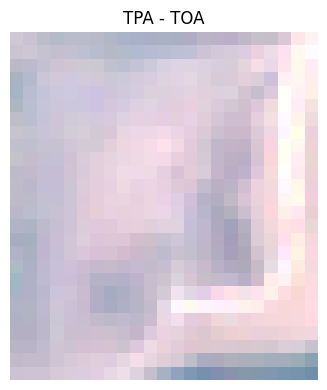

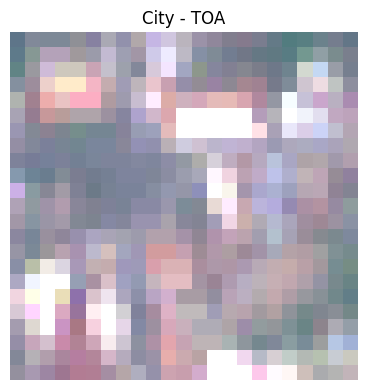

In [366]:
animate_patch_history(tpa_patch_histories, 'TPA - TOA')
animate_patch_history(patch_histories[0], 'City - TOA')

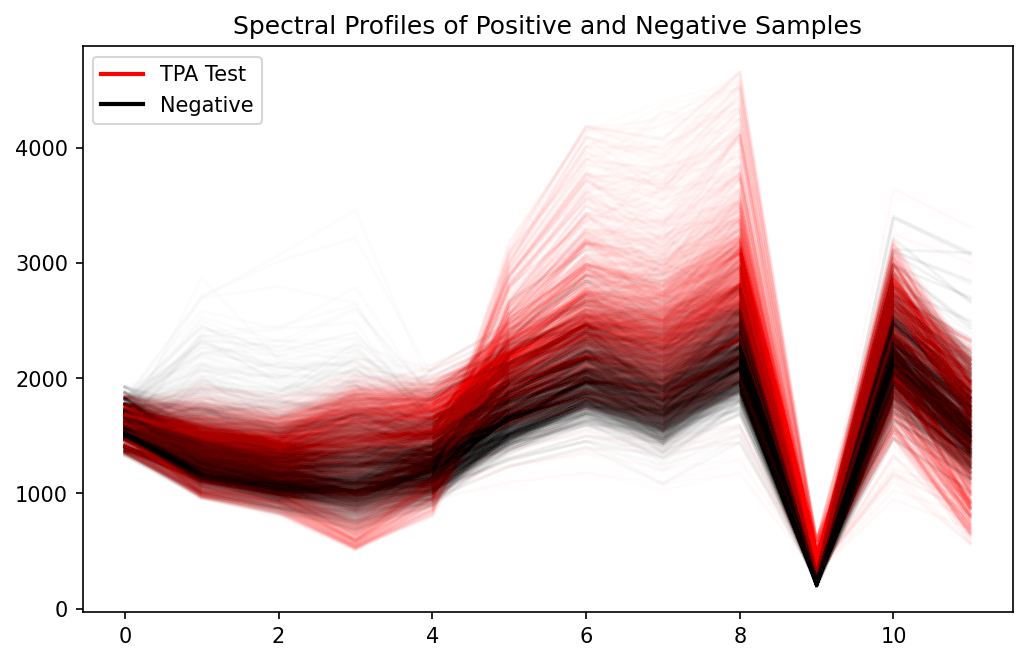

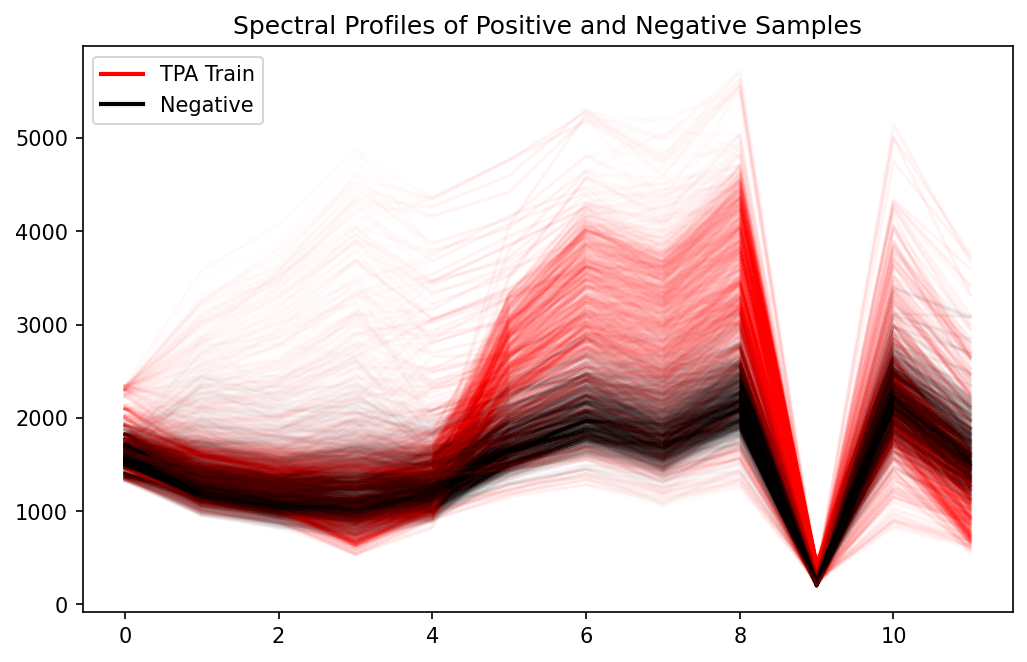

In [358]:
# Plot pixel spectral profiles to observe any anomalies
num_samples = 2000
plt.figure(figsize=(8,5), dpi=150, facecolor=(1,1,1))
for i in range(num_samples):
    neg_index = np.random.randint(len(negative_data))
    pos_index = np.random.randint(len(positive_test))
    plt.plot(positive_test[i], c='r', alpha=0.01);
    plt.plot(negative_data[i], c='k', alpha=0.01);

custom_lines = [Line2D([0], [0], color='r', lw=2),
                Line2D([0], [0], color='k', lw=2)]
plt.legend(custom_lines, ['TPA Test', 'Negative'], loc='upper left')
plt.title('Spectral Profiles of Positive and Negative Samples')
plt.show()

plt.figure(figsize=(8,5), dpi=150, facecolor=(1,1,1))
for i in range(num_samples):
    neg_index = np.random.randint(len(negative_data))
    pos_index = np.random.randint(len(positive_train))
    plt.plot(positive_train[i], c='r', alpha=0.01);
    plt.plot(negative_data[i], c='k', alpha=0.01);

custom_lines = [Line2D([0], [0], color='r', lw=2),
                Line2D([0], [0], color='k', lw=2)]
plt.legend(custom_lines, ['TPA Train', 'Negative'], loc='upper left')
plt.title('Spectral Profiles of Positive and Negative Samples')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(11, 18)
1917


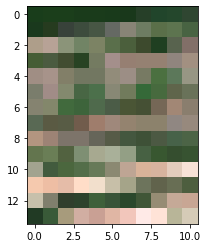

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2086


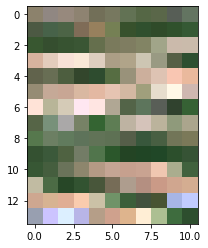

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0


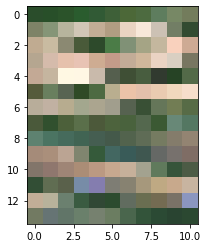

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2086


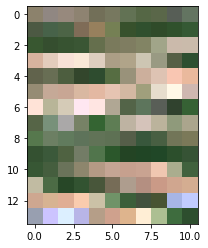

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2311


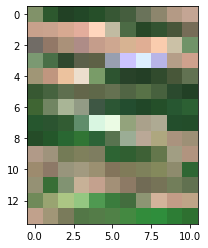

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1890


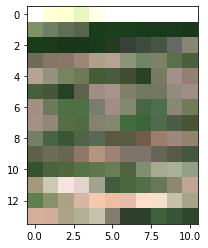

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2311


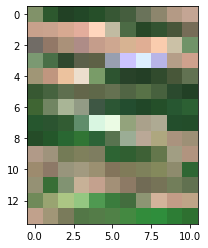

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2311


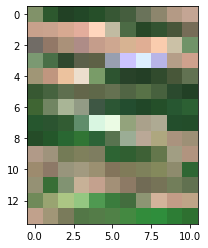

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2311


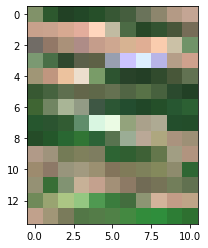

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2311


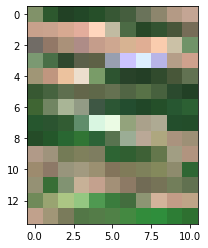

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2311


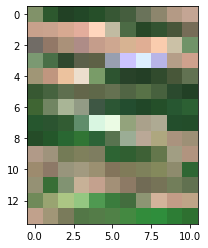

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2311


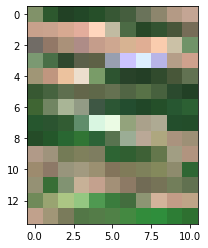

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2311


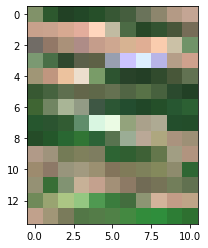

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2086


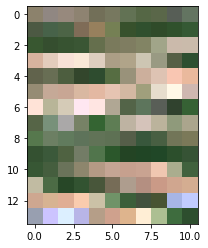

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1736


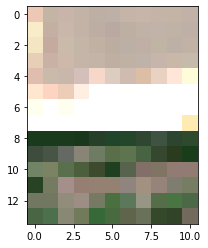

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2086


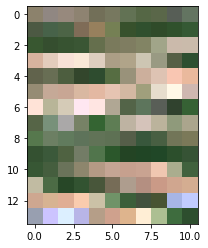

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2311


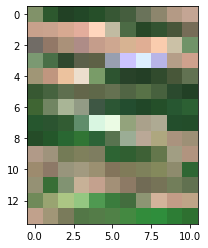

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2311


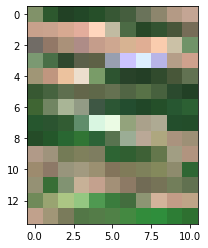

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1734


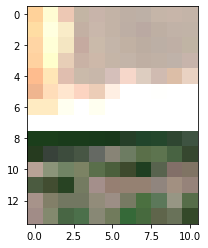

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2311


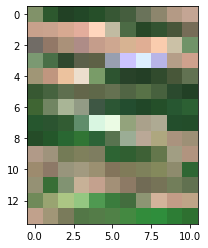

In [293]:
print(tpa_patch_histories['2019-01-01']['TPA Jungut Batu']['B2'].shape)

img = np.zeros((14,11,3))

for i in range(20):
    offset = np.shape(positive_pixel_vectors[i])[0]
    print(offset)
    for i in range(14):
        for j in range(11):
            img[i,j,0] = positive_train[offset + (i*23 + j)][3]
            img[i,j,1] = positive_train[offset + (i*23 + j)][2]
            img[i,j,2] = positive_train[offset + (i*23 + j)][1]
    plt.imshow(img / 2000)
    plt.show()

In [283]:
reversed(positive_train[offset + (i*23 + j)])